# Analysis of single-cell RNA-seq data for Mouse Retinal Development


This Python notebook performs an analysis of the cell types and their marker genes on provided GSE118614_Smart dataset.

# Analysis of SmartSeq data


In [1]:
import numpy as np
import pandas as pd
# from pandas.core import frame
import scanpy as sc
# import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import DistanceMetric
# from sklearn.decoHeylsition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import re
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

The droplet-based 10X Genomics Chromium (10X) approach and the plate-based Smart-seq2 full-length method are two frequently used scRNA-seq platforms. [wang(21)](https://www.sciencedirect.com/science/article/pii/S1672022921000486)  thoroughly and systematicly compares their advantages and limitations. We won't go into details, but it seems main difference in our analysis on count matrices are just on how to set thresholds for performing basic filtering. 

In [2]:
results_file = 'swrite/retsmart.h5ad'  # the file that will store the analysis results


adata = sc.read_10x_mtx(
    'sdata',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


genes= pd.read_csv('sdata/GSE118614_Smart_genes.tsv', header=0, sep='\t')


cells = pd.read_csv('sdata/GSE118614_Smart_cells.tsv', header=0, sep='\t')
adata.obs['CellType']=cells['CellType'].values
adata.obs['Age']=cells['Age'].values
adata.obs['Plate']=cells['Plate'].values


Keeping Early RPC cells only, 

In [3]:
adata=adata[adata.obs.CellType.str.startswith('Early'), :]


 Calculate  mitochondrial genes, ribosormal genes, and hemoglobin genes content

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
adata.var['hb'] = adata.var_names.str.startswith(("Hba","Hbb","Hbq"))

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

Trying to set attribute `.var` of view, copying.


C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Age' as categorical
C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reord

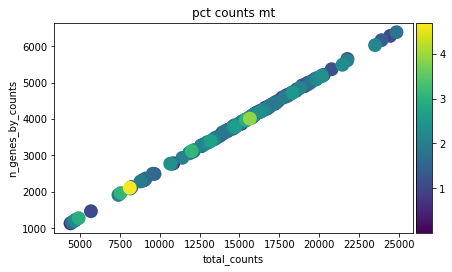

In [5]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')


In [6]:
print("filtered %d cells with more than 10 percent mitochondrial reads" %(sum(adata.obs['pct_counts_mt'] >= 10)))


filtered 0 cells with more than 10 percent mitochondrial reads


In [7]:
adata = adata[adata.obs['pct_counts_mt'] < 10, :]


In [8]:
adata = adata[adata.obs['n_genes_by_counts'] < 7000, :]

sc.pp.filter_cells(adata, min_genes=500)

adata_all_genes = adata.copy()
sc.pp.filter_genes(adata, min_cells=3)


Trying to set attribute `.obs` of view, copying.


See how many cells and genes left after filtering


In [9]:
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')

Data has 13466 genes in 156 cells


Delete unususally high expressed genes, along with mito ang homoglobin geses.

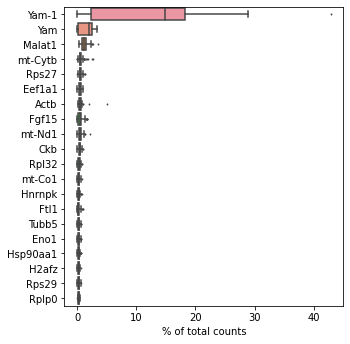

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [11]:
malat1_gene = adata.var_names.str.startswith('Malat1')
yam_genes = adata.var_names.str.startswith('Yam')


mito_genes = adata.var_names.str.startswith('mt-')
hb_genes = adata.var_names.str.startswith(("Hba","Hbb","Hbq"))
ribo_gene= adata.var_names.str.startswith(("Rps","Rpl"))

remove = np.add(mito_genes, malat1_gene)
remove = np.add(remove, yam_genes)
remove = np.add(remove, hb_genes)
remove = np.add(remove, ribo_gene)

keep = np.invert(remove)

adata = adata[:,keep]
sc.pp.filter_cells(adata, min_genes=1)

Trying to set attribute `.obs` of view, copying.


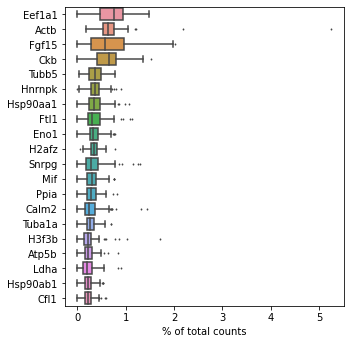

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [13]:
# See how many cells and genes left after filtering
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')


Data has 13331 genes in 156 cells


In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)


## Normalisation and Logarithmize the data:



In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

sc.pp.log1p(adata) # log(X+1)
adata.raw = adata

## Identifying highly variable genes¶


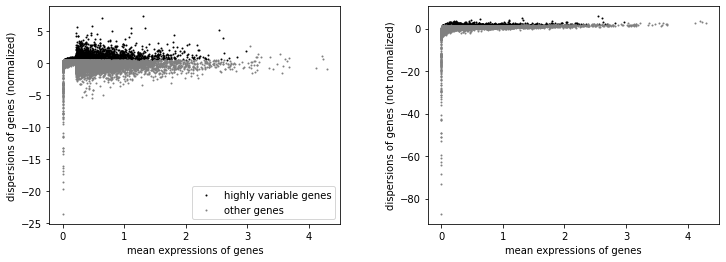

Data has 1801 genes in 156 cells


In [16]:

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3.0, min_disp=0.5)

sc.pl.highly_variable_genes(adata)
#filter to only include HVGs

adata = adata[:, adata.var.highly_variable]

print('Data has', adata.n_vars, 'genes in', adata.n_obs, 'cells')

## Dimensionality reduction
### Calculate PCA


In [17]:
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred'])


In [18]:

sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


Trying to set attribute `.obs` of view, copying.


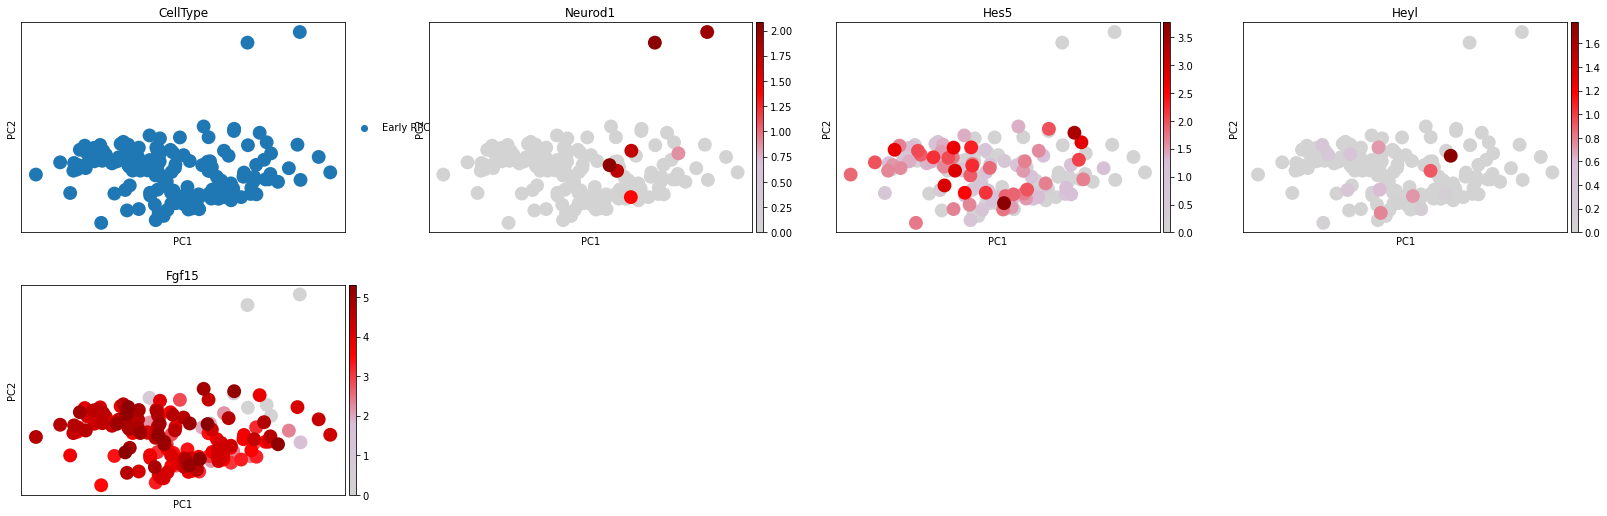

In [19]:
# Plot
sc.pl.pca_scatter(adata, color=['CellType', 'Neurod1', 'Hes5', 'Heyl', 'Fgf15'], color_map=cmap)


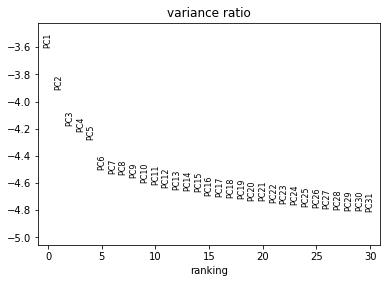

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)


## Compute the neighborhood graph and perform clustering


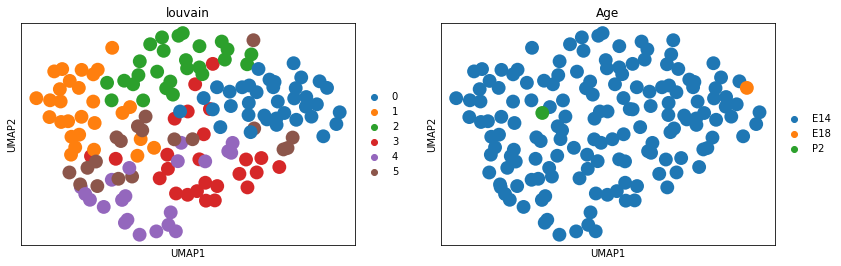

The CellType Rand index is 0.0
The Age Rand index is -0.0


In [21]:
sc.pp.neighbors(adata, n_neighbors=9, n_pcs=22)
sc.tl.louvain(adata, resolution=1, random_state=0)
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
# Visualizing data with umap

sc.pl.umap(adata, color= ['louvain', 'Age'])

rand_index = adjusted_rand_score(labels_true = adata.obs['CellType'], labels_pred = adata.obs['louvain'])
rand_index_age = adjusted_rand_score(labels_true = adata.obs['Age'], labels_pred = adata.obs['louvain'])
print('The CellType Rand index is', round(rand_index, 2))
print('The Age Rand index is', round(rand_index_age, 2))

Compute number of cells in each subgroup, 

In [22]:
cluster_distrib = adata.obs.groupby("louvain").count()["n_genes"]
age_distrib = adata.obs.groupby("Age").count()["n_genes"]


for c in cluster_distrib.index:
    print(
        "Cluster %s (%d cells):"
        % (
            c,
            cluster_distrib[c],
        )
    )


Cluster 0 (37 cells):
Cluster 1 (28 cells):
Cluster 2 (26 cells):
Cluster 3 (25 cells):
Cluster 4 (21 cells):
Cluster 5 (19 cells):


In [23]:
for ct in adata.obs.Age.cat.categories:
    print(
        "Age %s (%d cells):"
        % (
            ct,
            age_distrib[ct],
        )
    )  
    

Age E14 (154 cells):
Age E18 (1 cells):
Age P2 (1 cells):


Similarities between the obtained lovain groups and import cell type, 

Rename louvain cell cluster labels to their similar groups in cell type grouping. 

## Calculate diffusion maps


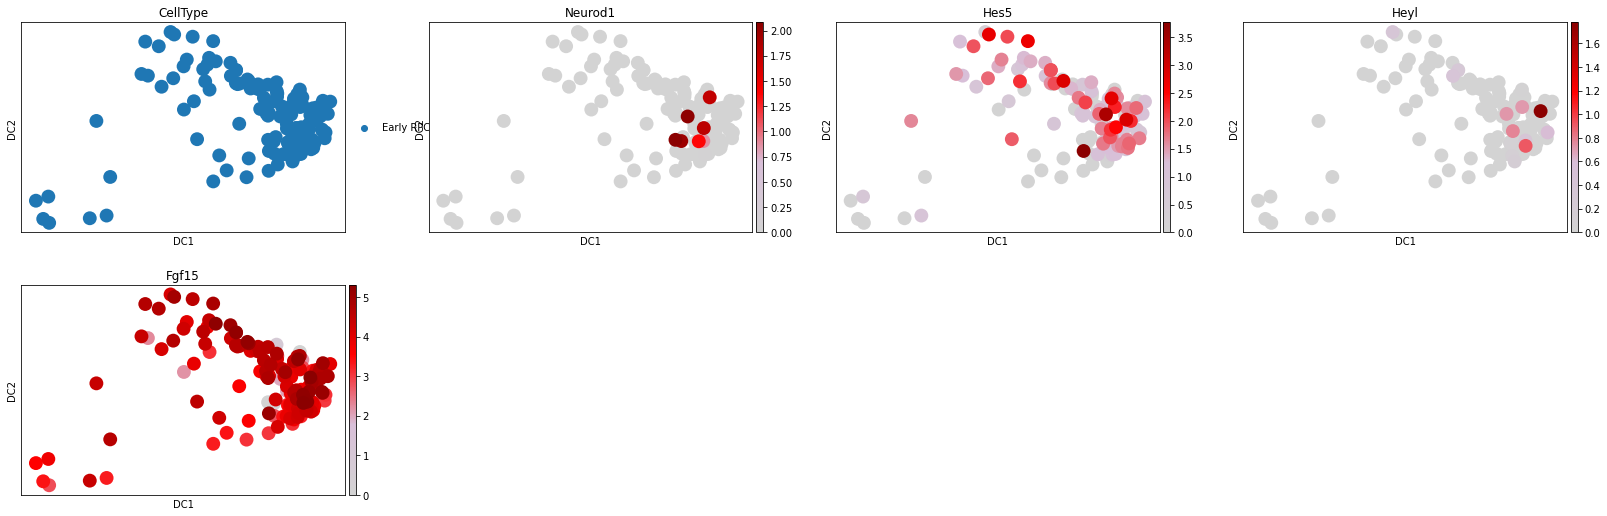

In [24]:
sc.tl.diffmap(adata)

sc.pl.diffmap(adata, color=['CellType', 'Neurod1', 'Hes5', 'Heyl', 'Fgf15'], color_map=cmap)

## find marker genes


method='wilcoxon', group_by='louvain'


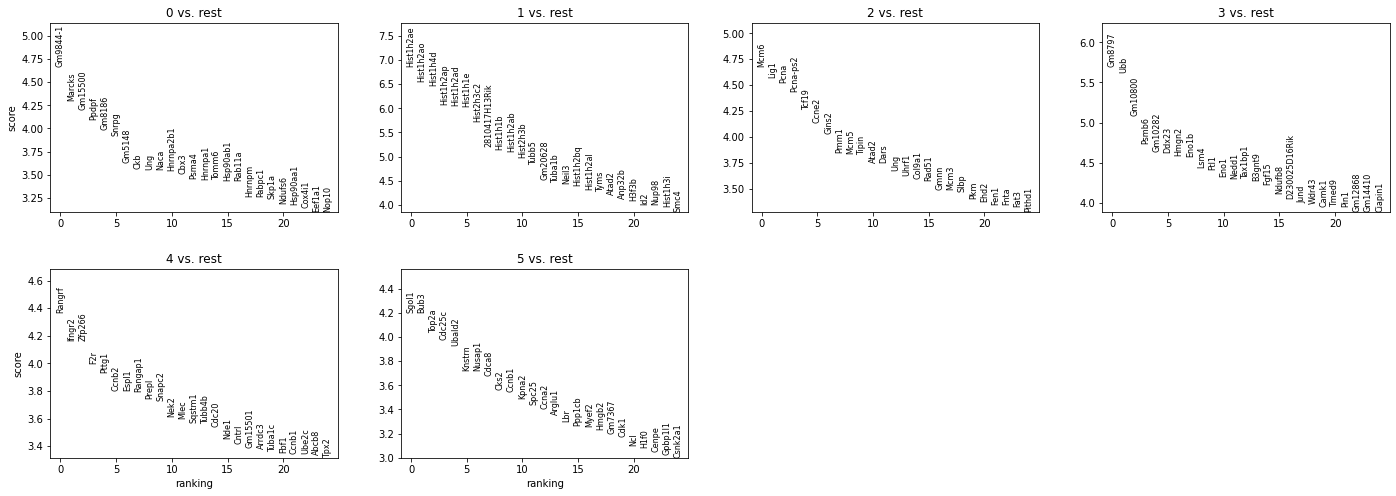

In [25]:
n_genes=25
sc.tl.rank_genes_groups(adata, 'louvain' ,n_genes=n_genes, method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon")


 method='wilcoxon', group_by='CellType'


method='wilcoxon', group_by='Age'


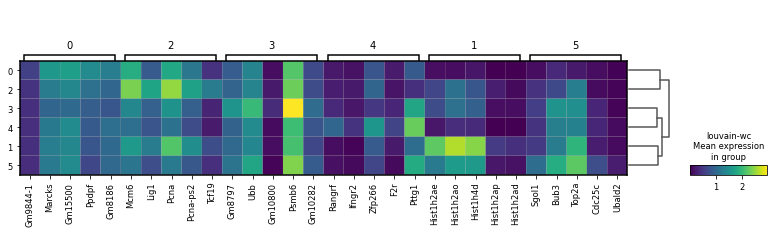

In [26]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="louvain", colorbar_title ='louvain-wc\nMean expression\nin group')


In [27]:
pd.DataFrame(adata.uns['wilcoxon']['names']).head(10)

,0,1,2,3,4,5
0,Gm9844-1,Hist1h2ae,Mcm6,Gm8797,Rangrf,Sgol1
1,Marcks,Hist1h2ao,Lig1,Ubb,Ifngr2,Bub3
2,Gm15500,Hist1h4d,Pcna,Gm10800,Zfp266,Top2a
3,Ppdpf,Hist1h2ap,Pcna-ps2,Psmb6,F2r,Cdc25c
4,Gm8186,Hist1h2ad,Tcf19,Gm10282,Pttg1,Ubald2
5,Snrpg,Hist1h1e,Ccne2,Ddx23,Ccnb2,Knstrn
6,Gm5148,Hist2h3c2,Gins2,Hmgn2,Espl1,Nusap1
7,Ckb,2810417H13Rik,Pmm1,Eno1b,Rangap1,Cdca8
8,Ung,Hist1h1b,Mcm5,Lsm4,Prepl,Cks2
9,Naca,Hist1h2ab,Tipin,Ftl1,Snapc2,Ccnb1


 Marker genes without using raw data


C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\scanpy\tools\_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


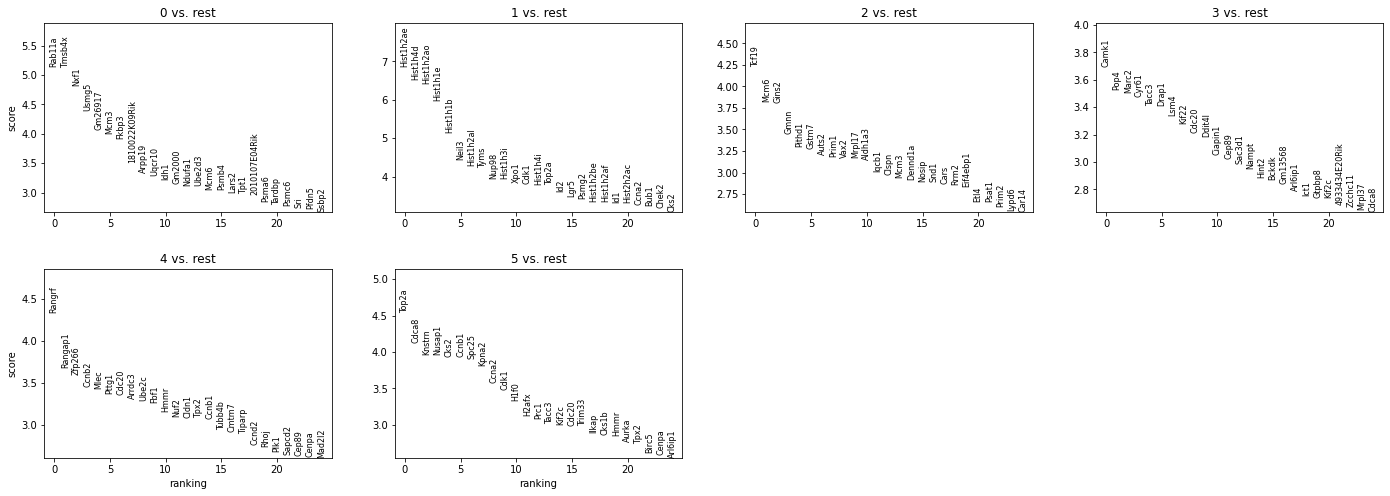

In [28]:
sc.tl.rank_genes_groups(adata, 'louvain' ,n_genes=n_genes, method='wilcoxon',use_raw=False, key_added = "rfwilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "rfwilcoxon")     

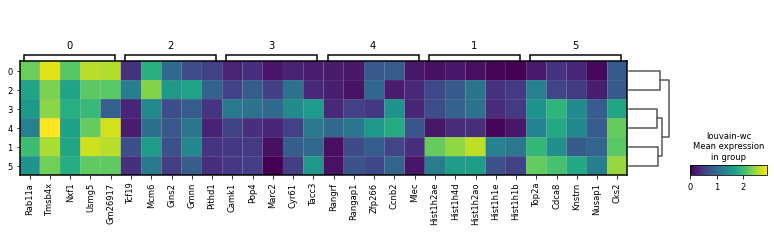

In [29]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="rfwilcoxon", groupby="louvain", colorbar_title ='louvain-wc\nMean expression\nin group')

In [30]:
pd.DataFrame(adata.uns['rfwilcoxon']['names']).head(10)



,0,1,2,3,4,5
0,Rab11a,Hist1h2ae,Tcf19,Camk1,Rangrf,Top2a
1,Tmsb4x,Hist1h4d,Mcm6,Pop4,Rangap1,Cdca8
2,Nxf1,Hist1h2ao,Gins2,Marc2,Zfp266,Knstrn
3,Usmg5,Hist1h1e,Gmnn,Cyr61,Ccnb2,Nusap1
4,Gm26917,Hist1h1b,Pithd1,Tacc3,Mlec,Cks2
5,Mcm3,Neil3,Gstm7,Drap1,Pttg1,Ccnb1
6,Fkbp3,Hist1h2al,Auts2,Lsm4,Cdc20,Spc25
7,1810022K09Rik,Tyms,Prim1,Kif22,Arrdc3,Kpna2
8,Arpp19,Nup98,Vax2,Cdc20,Ube2c,Ccna2
9,Uqcr10,Hist1h3i,Mrpl17,Ddit4l,Fbf1,Cdk1
